## SI epidemic simulations: communities

In [56]:
import networkx as nx
import EoN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

from tqdm.notebook import tqdm

In [57]:
TAU = 0.1
TMAX = 20.0
N_TRIALS = 5
N_RUNS = 5

In [58]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

# Import communities
node_community = pd.read_csv('data/task1/communities.csv', index_col=0)

# Extract 5 largest communities
print(node_community.value_counts().head())

top_community_ids = node_community.value_counts().head().index.get_level_values(0).to_list()
top_community_nodes = {community_rank: node_community[node_community == community_id].dropna().index.to_list()
                       for community_rank, community_id in enumerate(top_community_ids)}

modularity_class
11                  5757
8                   5358
7                   4408
16                  2951
10                  2334
dtype: int64


### Functions

In [59]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], initial_community: int, n_runs: int) -> np.ndarray:
    """Simulate SIR model for a given community and return the number of infected nodes at each time step. Returns an array of shape (n_runs, n_communities, n_time_steps)."""

    t_grid = np.linspace(0, tmax, 100)
    infected = np.zeros((n_runs, len(top_community_nodes), len(t_grid)))

    for run in range(n_runs):
        initial_infected = np.random.choice(top_community_nodes[initial_community])
        print(f"Initial infected: {initial_infected} (community {initial_community + 1})")
        
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=initial_infected, tmax=tmax, return_full_data=True)
        
        for community, nodes in top_community_nodes.items():
            I = [sum([1 for status in sim.get_statuses(nodes, t).values() if status == 'I']) for t in t_grid]
            infected[run, community] = I
        
    mean_infected = np.mean(infected, axis=0)

    return mean_infected

In [60]:
def run_trials(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], n_trials: int, n_runs: int) -> np.ndarray:
    """Run multiple trials for each community and return the average number of infected nodes at each time step. Returns an array of shape (n_trials, n_communities, n_time_steps)."""

    # Dictionary to store final results
    community_infected = {}

    for inital_community in top_community_nodes:

        # Array to store results of each trial
        mean_trial_infected = np.zeros((n_trials, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))

        print(f"Community {inital_community + 1}")

        for trial in tqdm(range(n_trials)):

            # Run simulations
            mean_run_infected = simulate_si(G, tau=tau, tmax=tmax, n_runs=n_runs,
                                            top_community_nodes=top_community_nodes,
                                            initial_community=inital_community)

            # Store results
            mean_trial_infected[trial] = mean_run_infected

        # Average over trials
        mean_trial_infected = np.mean(mean_trial_infected, axis=0)

        # Store results
        community_infected[inital_community] = mean_trial_infected
    
    return community_infected

In [61]:
def plot_community_infected(community_infected: dict[int, np.ndarray], title: str, log: bool=False, save: bool=False) -> None:
    """Plot the number of infected nodes for each community at each time step."""

    fig = plt.figure(figsize=(6, 8))
    fig.suptitle(f"SI epidemic: infection curve\nfor top communities in {title} network\ntau={TAU}, tmax={TMAX}, n_trials={N_TRIALS}, n_runs={N_RUNS}")
    gs = gridspec.GridSpec(3, 4, figure=fig)

    axs = [fig.add_subplot(gs[0, :2])]
    axs += [fig.add_subplot(gs[0, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, :2], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[2, :2], sharex=axs[0], sharey=axs[0])]

    for ax, (initial_community, data) in zip(axs, community_infected.items()):
        for i in range(5):
            ax.plot(np.linspace(0, TMAX, 100), data[i], label=f"Community {i + 1}")
        ax.set_title(f"Initial community: rank {initial_community + 1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Infected nodes")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower right', bbox_to_anchor=(0.9, 0.1))

    if log:
        axs[0].set_yscale('log')

    fig.tight_layout()

    if save:
        fig.savefig(f"results/task3/tau{str(TAU).replace('.', '_')}_tmax{str(TMAX).replace('.', '_')}_ntrials{N_TRIALS}_nruns{N_RUNS}_{title.lower()}_{'log' if log else 'lin'}.png", dpi=fig.dpi, bbox_inches='tight')

    plt.show()

## Reddit graph

In [62]:
# Run trials
community_infected_reddit = run_trials(G, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=N_TRIALS, n_runs=N_RUNS)

Community 1


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 28563 (community 1)
Initial infected: 13737 (community 1)
Initial infected: 16641 (community 1)
Initial infected: 20065 (community 1)
Initial infected: 23586 (community 1)
Initial infected: 11751 (community 1)
Initial infected: 35671 (community 1)
Initial infected: 748 (community 1)
Initial infected: 7544 (community 1)
Initial infected: 16285 (community 1)
Initial infected: 3753 (community 1)
Initial infected: 27759 (community 1)
Initial infected: 12567 (community 1)
Initial infected: 25884 (community 1)
Initial infected: 17515 (community 1)
Initial infected: 31030 (community 1)
Initial infected: 17338 (community 1)
Initial infected: 9 (community 1)
Initial infected: 1891 (community 1)
Initial infected: 3081 (community 1)
Initial infected: 26568 (community 1)
Initial infected: 19341 (community 1)
Initial infected: 14993 (community 1)
Initial infected: 10560 (community 1)
Initial infected: 32839 (community 1)
Community 2


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 13762 (community 2)
Initial infected: 34645 (community 2)
Initial infected: 11247 (community 2)
Initial infected: 19112 (community 2)
Initial infected: 2544 (community 2)
Initial infected: 14155 (community 2)
Initial infected: 26616 (community 2)
Initial infected: 33944 (community 2)
Initial infected: 9814 (community 2)
Initial infected: 21786 (community 2)
Initial infected: 15275 (community 2)
Initial infected: 33177 (community 2)
Initial infected: 25376 (community 2)
Initial infected: 34740 (community 2)
Initial infected: 3091 (community 2)
Initial infected: 6672 (community 2)
Initial infected: 24457 (community 2)
Initial infected: 34209 (community 2)
Initial infected: 25807 (community 2)
Initial infected: 19131 (community 2)
Initial infected: 24736 (community 2)
Initial infected: 23979 (community 2)
Initial infected: 34546 (community 2)
Initial infected: 6239 (community 2)
Initial infected: 6016 (community 2)
Community 3


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 22135 (community 3)
Initial infected: 8046 (community 3)
Initial infected: 10603 (community 3)
Initial infected: 32303 (community 3)
Initial infected: 635 (community 3)
Initial infected: 13617 (community 3)
Initial infected: 12281 (community 3)
Initial infected: 17738 (community 3)
Initial infected: 17048 (community 3)
Initial infected: 25129 (community 3)
Initial infected: 10762 (community 3)
Initial infected: 17760 (community 3)
Initial infected: 18796 (community 3)
Initial infected: 1215 (community 3)
Initial infected: 2660 (community 3)
Initial infected: 17856 (community 3)
Initial infected: 20768 (community 3)
Initial infected: 6642 (community 3)
Initial infected: 15500 (community 3)
Initial infected: 14480 (community 3)
Initial infected: 33746 (community 3)
Initial infected: 7558 (community 3)
Initial infected: 218 (community 3)
Initial infected: 4667 (community 3)
Initial infected: 16461 (community 3)
Community 4


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 32121 (community 4)
Initial infected: 34528 (community 4)
Initial infected: 19709 (community 4)
Initial infected: 34246 (community 4)
Initial infected: 18291 (community 4)
Initial infected: 10076 (community 4)
Initial infected: 14772 (community 4)
Initial infected: 16984 (community 4)
Initial infected: 30157 (community 4)
Initial infected: 17075 (community 4)
Initial infected: 10485 (community 4)
Initial infected: 31434 (community 4)
Initial infected: 23408 (community 4)
Initial infected: 31239 (community 4)
Initial infected: 35698 (community 4)
Initial infected: 31927 (community 4)
Initial infected: 21633 (community 4)
Initial infected: 34804 (community 4)
Initial infected: 11716 (community 4)
Initial infected: 10741 (community 4)
Initial infected: 22173 (community 4)
Initial infected: 12941 (community 4)
Initial infected: 31839 (community 4)
Initial infected: 24016 (community 4)
Initial infected: 1368 (community 4)
Community 5


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 21459 (community 5)
Initial infected: 9269 (community 5)
Initial infected: 12014 (community 5)
Initial infected: 22607 (community 5)
Initial infected: 5274 (community 5)
Initial infected: 3342 (community 5)
Initial infected: 35555 (community 5)
Initial infected: 25650 (community 5)
Initial infected: 35229 (community 5)
Initial infected: 12055 (community 5)
Initial infected: 7712 (community 5)
Initial infected: 9276 (community 5)
Initial infected: 25753 (community 5)
Initial infected: 640 (community 5)
Initial infected: 7550 (community 5)
Initial infected: 31216 (community 5)
Initial infected: 19876 (community 5)
Initial infected: 27423 (community 5)
Initial infected: 32971 (community 5)
Initial infected: 22346 (community 5)
Initial infected: 28333 (community 5)
Initial infected: 33397 (community 5)
Initial infected: 34607 (community 5)
Initial infected: 17255 (community 5)
Initial infected: 15581 (community 5)


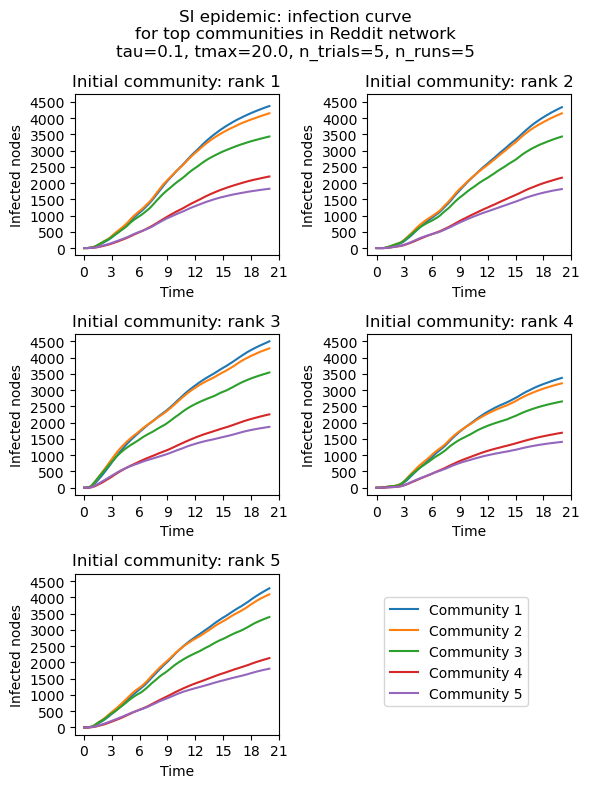

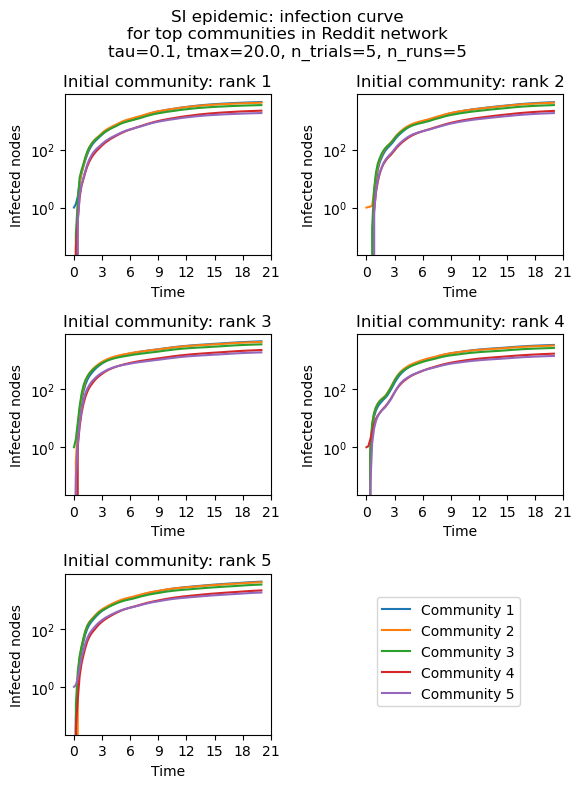

In [63]:
# Plot results
plot_community_infected(community_infected_reddit, title='Reddit', log=False, save=True)
plot_community_infected(community_infected_reddit, title='Reddit', log=True, save=True)

## Random graph

In [64]:
# Create random graph with same number of nodes and edges
G_random = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

In [65]:
# Run trials
community_infected_random = run_trials(G_random, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=N_TRIALS, n_runs=N_RUNS)

Community 1


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 3928 (community 1)
Initial infected: 5934 (community 1)
Initial infected: 21679 (community 1)
Initial infected: 21650 (community 1)
Initial infected: 32610 (community 1)
Initial infected: 30547 (community 1)
Initial infected: 19502 (community 1)
Initial infected: 11663 (community 1)
Initial infected: 15470 (community 1)
Initial infected: 18485 (community 1)
Initial infected: 14902 (community 1)
Initial infected: 23728 (community 1)
Initial infected: 18178 (community 1)
Initial infected: 4563 (community 1)
Initial infected: 16892 (community 1)
Initial infected: 17008 (community 1)
Initial infected: 13350 (community 1)
Initial infected: 29319 (community 1)
Initial infected: 13345 (community 1)
Initial infected: 26783 (community 1)
Initial infected: 21113 (community 1)
Initial infected: 10026 (community 1)
Initial infected: 22562 (community 1)
Initial infected: 9050 (community 1)
Initial infected: 9050 (community 1)
Community 2


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 6477 (community 2)
Initial infected: 4541 (community 2)
Initial infected: 1209 (community 2)
Initial infected: 21849 (community 2)
Initial infected: 7850 (community 2)
Initial infected: 9694 (community 2)
Initial infected: 33543 (community 2)
Initial infected: 29223 (community 2)
Initial infected: 20117 (community 2)
Initial infected: 5428 (community 2)
Initial infected: 13659 (community 2)
Initial infected: 4503 (community 2)
Initial infected: 12262 (community 2)
Initial infected: 3057 (community 2)
Initial infected: 32811 (community 2)
Initial infected: 22592 (community 2)
Initial infected: 28724 (community 2)
Initial infected: 33365 (community 2)
Initial infected: 26111 (community 2)
Initial infected: 13385 (community 2)
Initial infected: 12662 (community 2)
Initial infected: 25120 (community 2)
Initial infected: 4520 (community 2)
Initial infected: 15719 (community 2)
Initial infected: 11851 (community 2)
Community 3


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 10738 (community 3)
Initial infected: 35774 (community 3)
Initial infected: 350 (community 3)
Initial infected: 5936 (community 3)
Initial infected: 23365 (community 3)
Initial infected: 14505 (community 3)
Initial infected: 27477 (community 3)
Initial infected: 22623 (community 3)
Initial infected: 17840 (community 3)
Initial infected: 23693 (community 3)
Initial infected: 15906 (community 3)
Initial infected: 14291 (community 3)
Initial infected: 15161 (community 3)
Initial infected: 9198 (community 3)
Initial infected: 29504 (community 3)
Initial infected: 21542 (community 3)
Initial infected: 17185 (community 3)
Initial infected: 17369 (community 3)
Initial infected: 3112 (community 3)
Initial infected: 8381 (community 3)
Initial infected: 35414 (community 3)
Initial infected: 3333 (community 3)
Initial infected: 25379 (community 3)
Initial infected: 32501 (community 3)
Initial infected: 20179 (community 3)
Community 4


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 4533 (community 4)
Initial infected: 34803 (community 4)
Initial infected: 23049 (community 4)
Initial infected: 2458 (community 4)
Initial infected: 23280 (community 4)
Initial infected: 20919 (community 4)
Initial infected: 8497 (community 4)
Initial infected: 1291 (community 4)
Initial infected: 33677 (community 4)
Initial infected: 22398 (community 4)
Initial infected: 1188 (community 4)
Initial infected: 27934 (community 4)
Initial infected: 29645 (community 4)
Initial infected: 9591 (community 4)
Initial infected: 32373 (community 4)
Initial infected: 125 (community 4)
Initial infected: 13697 (community 4)
Initial infected: 35188 (community 4)
Initial infected: 31702 (community 4)
Initial infected: 30164 (community 4)
Initial infected: 17351 (community 4)
Initial infected: 6692 (community 4)
Initial infected: 3278 (community 4)
Initial infected: 28766 (community 4)
Initial infected: 22709 (community 4)
Community 5


  0%|          | 0/5 [00:00<?, ?it/s]

Initial infected: 11250 (community 5)
Initial infected: 11808 (community 5)
Initial infected: 8055 (community 5)
Initial infected: 640 (community 5)
Initial infected: 25745 (community 5)
Initial infected: 28227 (community 5)
Initial infected: 13962 (community 5)
Initial infected: 21142 (community 5)
Initial infected: 19054 (community 5)
Initial infected: 10417 (community 5)
Initial infected: 1047 (community 5)
Initial infected: 17968 (community 5)
Initial infected: 12612 (community 5)
Initial infected: 28706 (community 5)
Initial infected: 23473 (community 5)
Initial infected: 15253 (community 5)
Initial infected: 19205 (community 5)
Initial infected: 34232 (community 5)
Initial infected: 32598 (community 5)
Initial infected: 12643 (community 5)
Initial infected: 29740 (community 5)
Initial infected: 21154 (community 5)
Initial infected: 5275 (community 5)
Initial infected: 25795 (community 5)
Initial infected: 14724 (community 5)


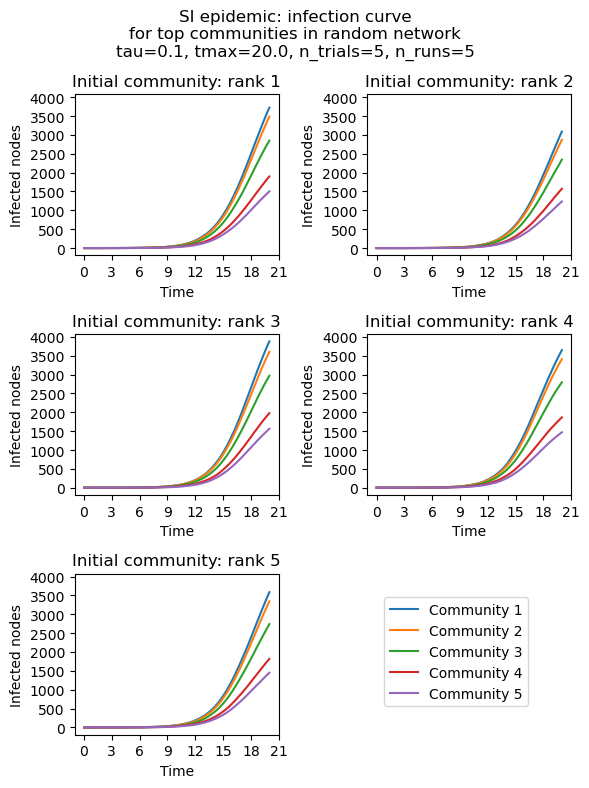

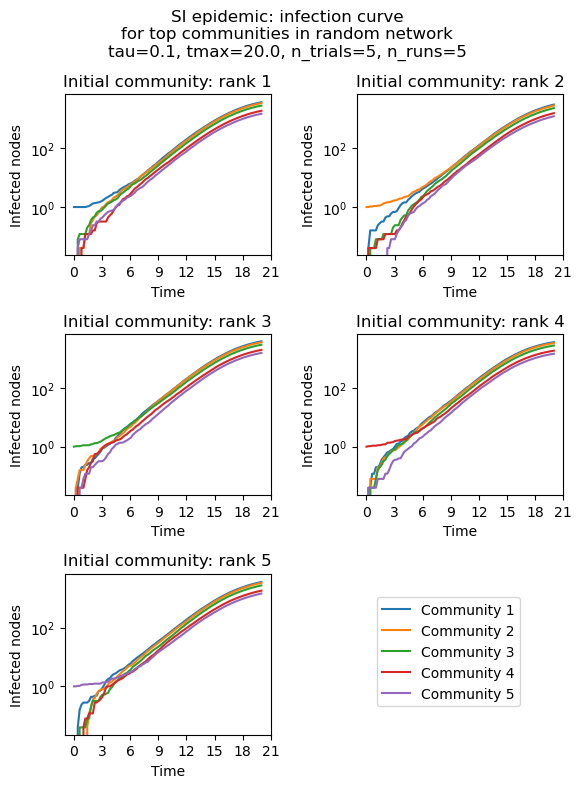

In [66]:
# Plot results
plot_community_infected(community_infected_random, title='random', log=False, save=True)
plot_community_infected(community_infected_random, title='random', log=True, save=True)